# ECSE 415 Assignment 3, Question 1
### Alex Hale | 260672475 | November 5, 2019

## Segmentation

In [7]:
# basic
import cv2
import numpy as np
import matplotlib.pyplot as plt

# SciKit
from skimage import segmentation, color
from skimage.future import graph
from sklearn.mixture import GaussianMixture

### 2.1 - K-means Clustering and Expectation Maximization
#### Implementations of K-Means and EMM as Functions

In [ ]:
def kmeans(data, K, stop, max_iter):
    # TODO
    pass

def emm(data, K):
    # TODO
    pass

#### Benchmark: OpenCV's K-Means Clustering and Expectation Maximization Algorithms

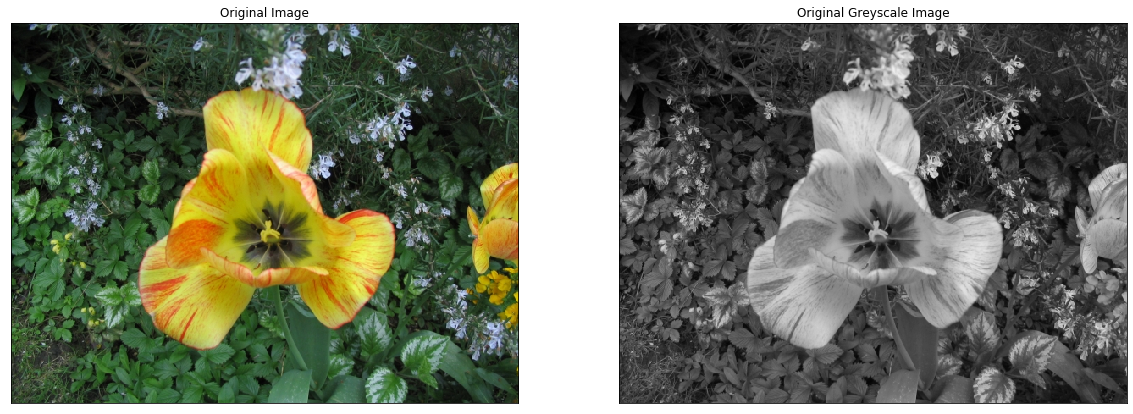

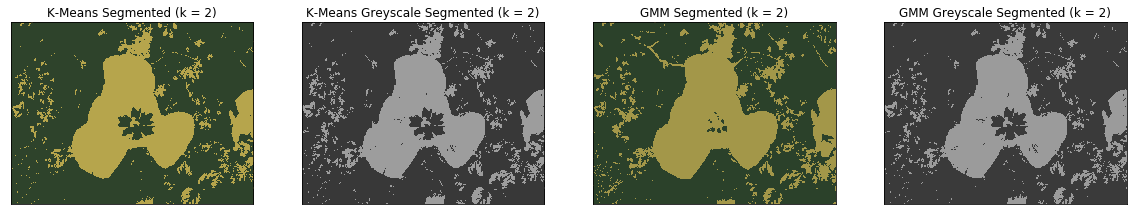

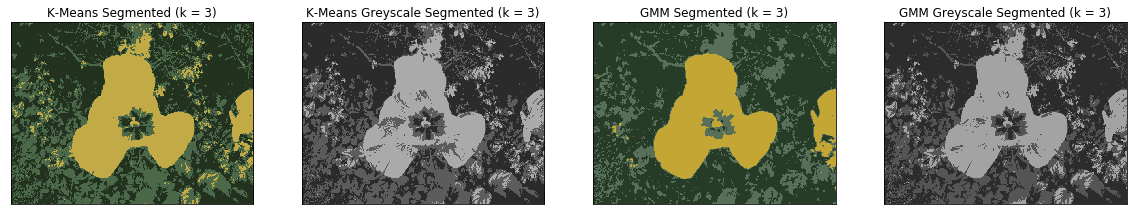

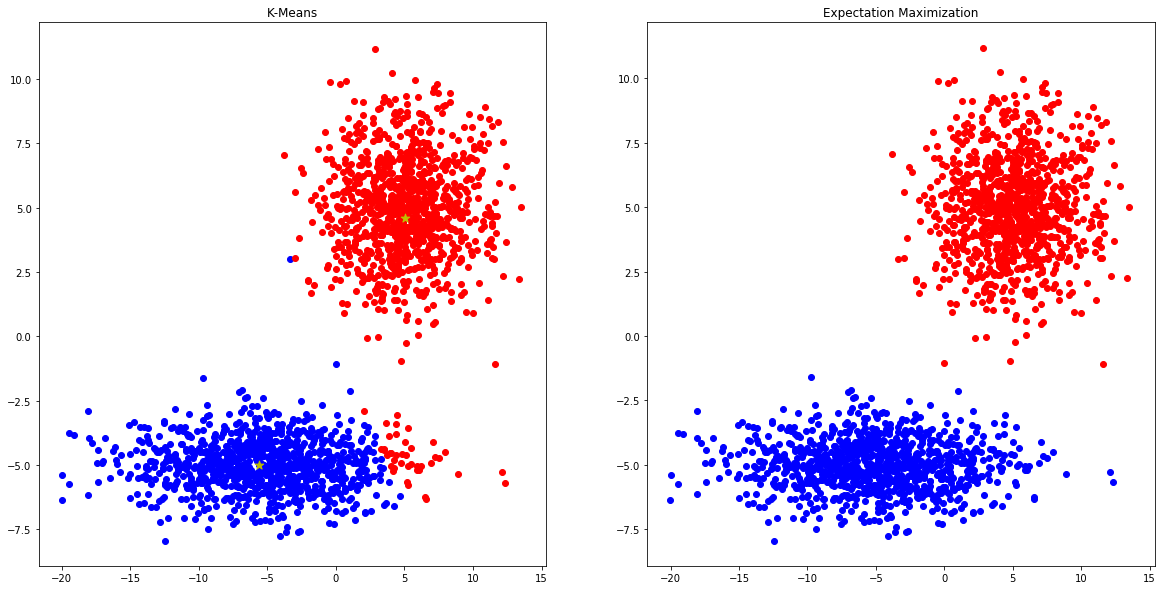

In [39]:
# load in image
img = cv2.cvtColor(cv2.imread('flower.jpg'), cv2.COLOR_BGR2RGB)
img_g = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# display original image
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(img), plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_g, cmap="gray", vmin=0, vmax=255), plt.title("Original Greyscale Image"), plt.xticks([]), plt.yticks([]) 

# reshape the image into an array of pixels (rather than a matrix)
img_data = np.float32(img.reshape((img.shape[0] * img.shape[1], 3)))
img_g_data = np.float32(img_g.reshape((img_g.shape[0] * img_g.shape[1], 1)))

# stopping criteria: stop when either 100 iterations or an accuracy of 1 is reached
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)

# iterate through number of clusters
for K in [2,3]:
    # execute K-Means
    compactness, labels, centers = cv2.kmeans(img_data, K, None, criteria, 10, flags=cv2.KMEANS_RANDOM_CENTERS)
    compactness_g, labels_g, centers_g = cv2.kmeans(img_g_data, K, None, criteria, 10, flags=cv2.KMEANS_RANDOM_CENTERS)

    # convert back into uint8 and create output image
    centers = np.uint8(centers)
    out = centers[labels.flatten()].reshape((img.shape))
    centers_g = np.uint8(centers_g)
    out_g = centers_g[labels_g.flatten()].reshape((img_g.shape))
    
    # execute expectation maximization
    gm = GaussianMixture(n_components=K, covariance_type='full')
    labels_gm = gm.fit_predict(img_data).reshape((img.shape[0], img.shape[1]))
    centers_gm = gm.means_
    gm_g = GaussianMixture(n_components=K, covariance_type='full')
    labels_gm_g = gm_g.fit_predict(img_g_data).reshape((img_g.shape))
    centers_gm_g = gm_g.means_
    
    # convert back into uint8 and create output images
    centers_gm = np.uint8(centers_gm)
    out_gm = centers_gm[labels_gm.flatten()].reshape((img.shape))
    centers_gm_g = np.uint8(centers_gm_g)
    out_gm_g = centers_gm_g[labels_gm_g.flatten()].reshape((img_g.shape))
    
    plt.figure(figsize=(20,20))
    plt.subplot(141)
    plt.imshow(out)
    plt.title("K-Means Segmented (k = {})".format(K)), plt.xticks([]), plt.yticks([])
    plt.subplot(142)
    plt.imshow(out_g, cmap='gray', vmin=0, vmax=255)
    plt.title("K-Means Greyscale Segmented (k = {})".format(K)), plt.xticks([]), plt.yticks([])
    plt.subplot(143)
    plt.imshow(out_gm)
    plt.title("GMM Segmented (k = {})".format(K)), plt.xticks([]), plt.yticks([])
    plt.subplot(144)
    plt.imshow(out_gm_g, cmap='gray', vmin=0, vmax=255)
    plt.title("GMM Greyscale Segmented (k = {})".format(K)), plt.xticks([]), plt.yticks([])
    plt.show()
    
# random data experimentation on K-Means and EM
data = np.float32(np.vstack((np.random.normal(loc=np.array([5,5]), scale=np.array([3,2]), size =(1000,2)),
                             np.random.normal(loc=np.array([-5,-5]), scale=np.array([5,1]), size=(1000,2)))))

compactness, labels, centers = cv2.kmeans(data, 2, None, criteria, 10, flags=cv2.KMEANS_RANDOM_CENTERS)
A = data[labels.ravel()==0]
B = data[labels.ravel()==1]

em_labels = GaussianMixture(2).fit_predict(data)
A_em = data[em_labels.ravel() == 0]
B_em = data[em_labels.ravel() == 1]

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.scatter(A[:,0], A[:,1], color='b')
plt.scatter(B[:,0], B[:,1], color='r')
plt.scatter(centers[:,0], centers[:,1], s=80, color='y', marker='*')
plt.title("K-Means")
plt.subplot(122)
plt.scatter(A_em[:,0], A_em[:,1], color='b')
plt.scatter(B_em[:,0], B_em[:,1], color='r')
plt.title("Expectation Maximization")
plt.show()

### 2.2 - Normalized Graph-Cut and Mean-Shift segmentation
#### Normalized Graph-Cut

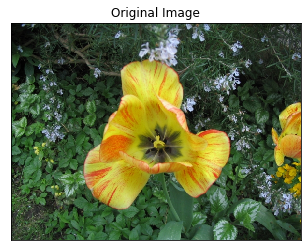

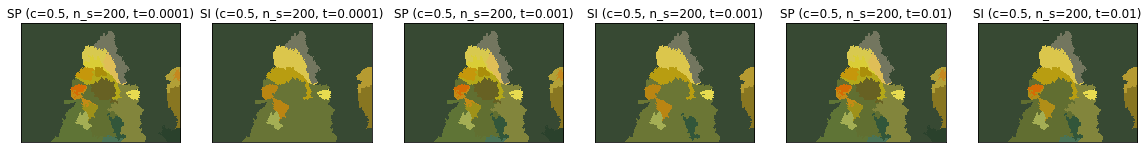

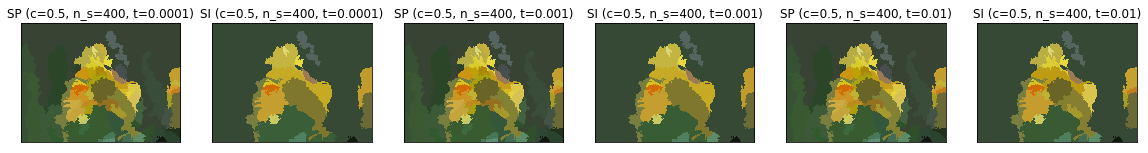

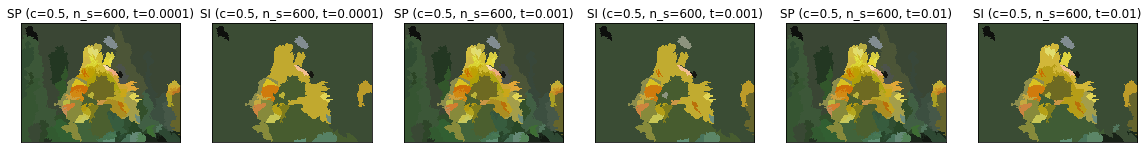

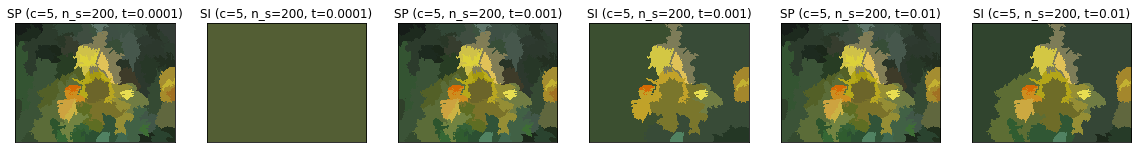

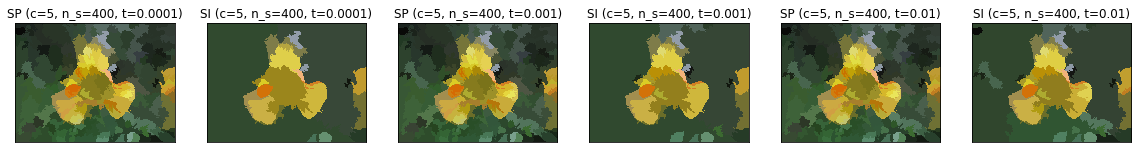

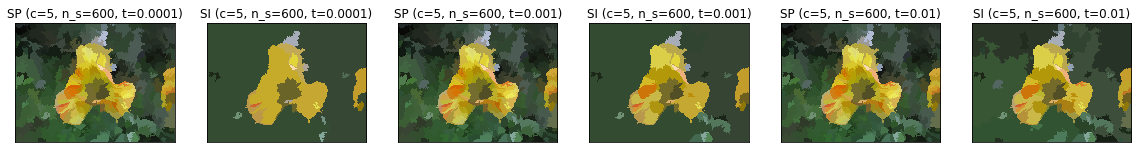

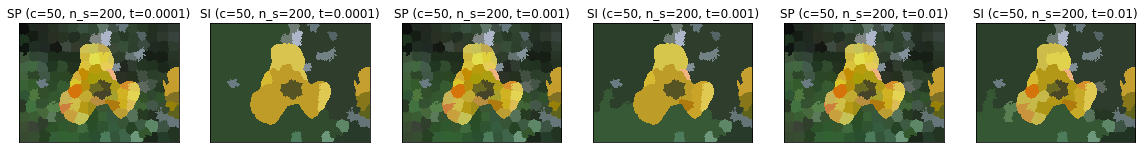

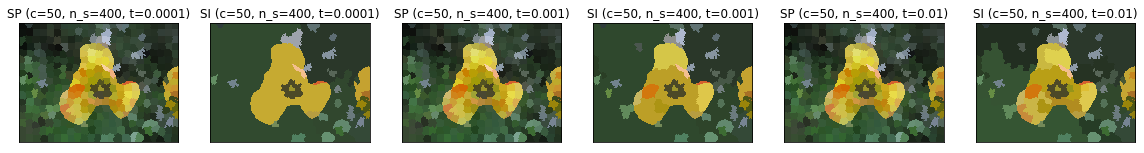

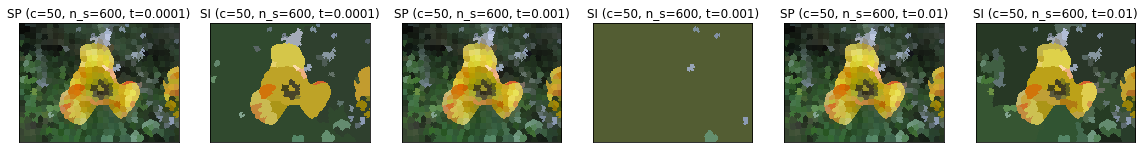

In [3]:
# Read image
img = cv2.cvtColor(cv2.imread('flower.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img), plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.show()

for c in [0.5, 5, 50]:
    for n_s in [200, 400, 600]:
        idx = 1
        plt.figure(figsize=(20,150))
        for t in [0.0001, 0.001, 0.01]:
            # generate super-pixels by applying K-Means
            super_pixels = segmentation.slic(img, compactness=c, n_segments=n_s)

            # build region adjacency graph
            g = graph.rag_mean_color(img, super_pixels, mode='similarity')

            # apply graph cut
            graph_cut = graph.cut_normalized(super_pixels, g, thresh=t)

            # display
            plt.subplot(int(str(16) + str(idx))), plt.imshow(color.label2rgb(super_pixels, img, kind='avg'))
            # super-pixel image
            plt.title("SP (c={}, n_s={}, t={})".format(c, n_s, t)), plt.xticks([]), plt.yticks([])
            plt.subplot(int(str(16) + str(idx+1))), plt.imshow(color.label2rgb(graph_cut, img, kind='avg'))
            # segmented image
            plt.title("SI (c={}, n_s={}, t={})".format(c, n_s, t)), plt.xticks([]), plt.yticks([])
            idx += 2
        plt.show()

Compactness: This parameter is the balance between color proximity and space proximity. A higher compactness value gives more weight to space proximity, which restricts the superpixels to be more square. A lower compactness value gives more weight to colour proximity, which for this image, makes the superpixels larger and more irregularly-shaped.

Number of Segments: This parameter is the (approximate) number of labels in the super-pixel (SP) output image. A higher number of labels means that more detail is preserved, while a lower number of labels results in less detail being preserved.

Threshold: This parameter limits the subdivision of the region adjacency graph. A subgraph won’t be further subdivided if the value of the N-cut exceeds this threshold. A larger threshold allows more of the detail from the super-pixel image into the segmented image, and vice versa. 

#### Mean-Shift Segmentation

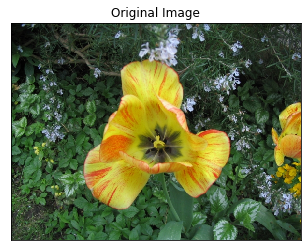

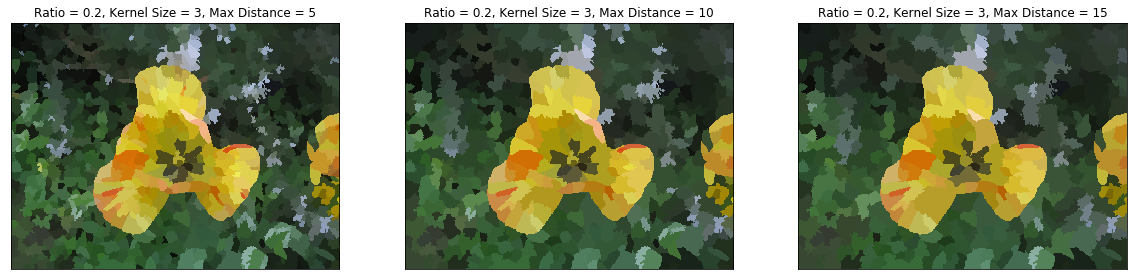

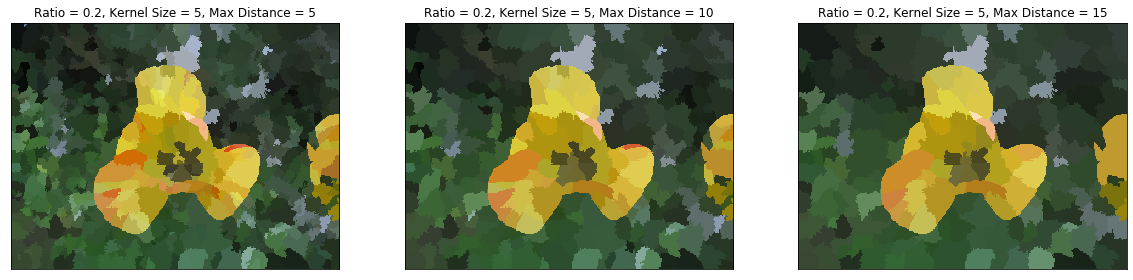

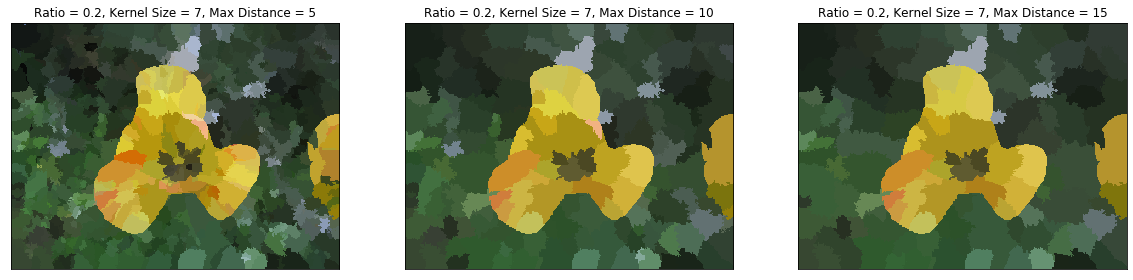

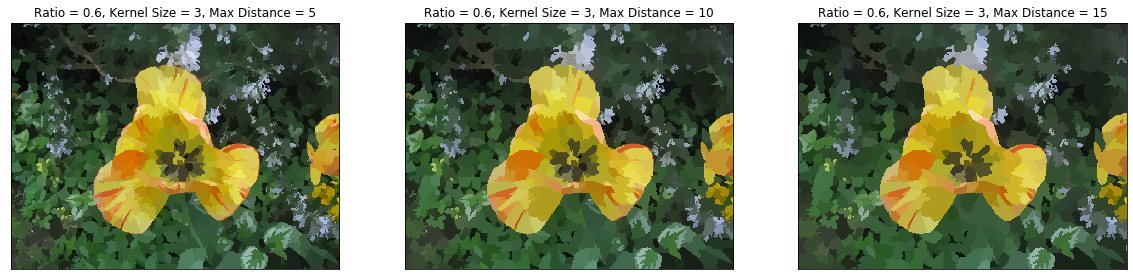

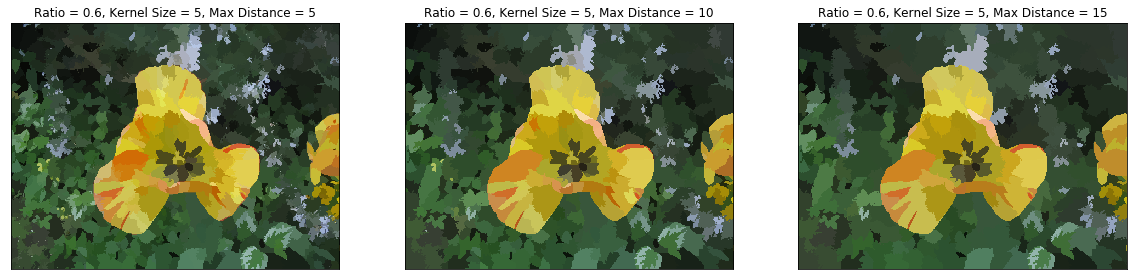

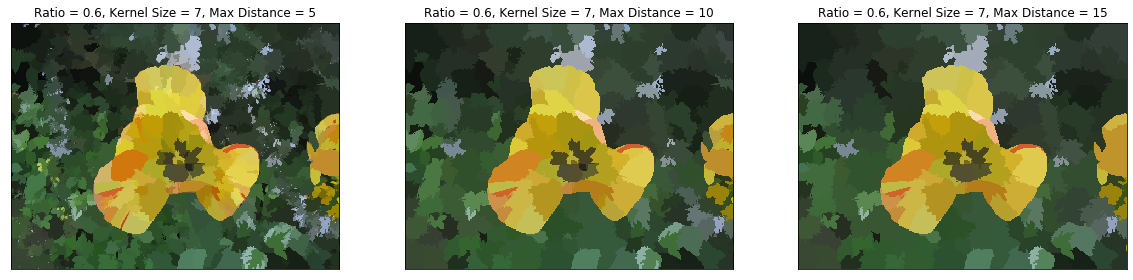

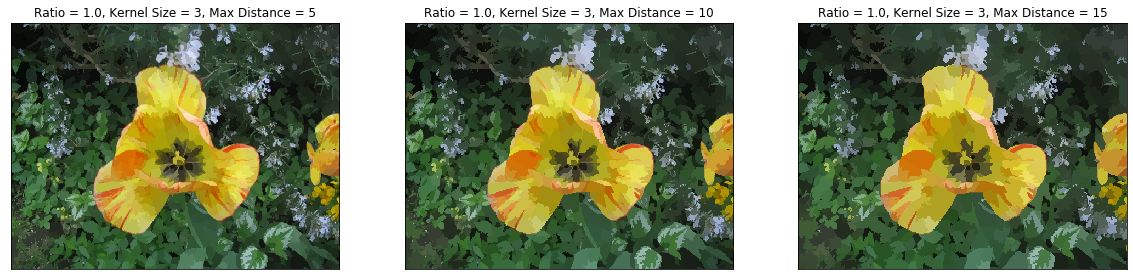

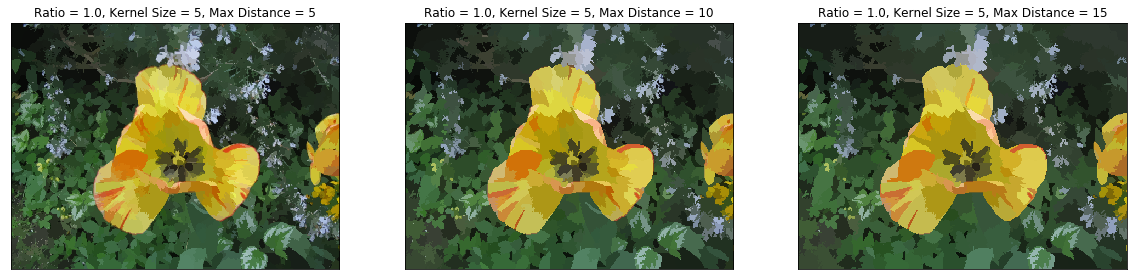

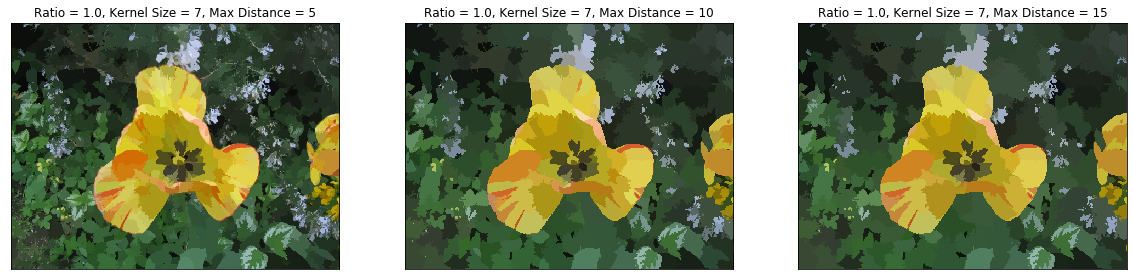

In [4]:
# Read image
img = cv2.cvtColor(cv2.imread('flower.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img), plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.show()

for r in [0.2, 0.6, 1.0]:
    for k in [3, 5, 7]:
        idx = 1
        plt.figure(figsize=(20, 20))
        for m in [5, 10, 15]:
            # apply meanshift
            label = segmentation.quickshift(img, ratio=r, kernel_size=k, max_dist=m)

            # display
            plt.subplot(int(str(13) + str(idx)))
            idx += 1
            plt.imshow(color.label2rgb(label, img, kind='avg'))
            plt.title("Ratio = {}, Kernel Size = {}, Max Distance = {}".format(r, k, m)), plt.xticks([]), plt.yticks([])
        plt.show()

Ratio: This parameter is the balance between colour-space proximity and image-space proximity, where 1.0 is entirely colour-space and 0.0 is entirely image-space. Practically, since this image has many areas with similar intensities but varying colours, this means that a higher ratio results in an image with more clusters (i.e. more detail), while a lower ratio results in an image with fewer clusters (i.e. less detail) of a more square shape. 

Kernel Size: This parameter is the width of the Gaussian kernel used to smooth the sample density. A higher kernel size performs more smoothing, which results in fewer clusters (i.e. less detail). A lower kernel size performs less smoothing, which results in more clusters (i.e. more detail).

Max Distance: This parameter is the maximum distance that a data point can be from a node in order to be included in that node's cluster. A higher max distance means that each cluster includes more data points, resulting in fewer clusters (i.e. less detail). A lower max distance means that each cluster includes fewer data points, resulting in more clusters (i.e. more detail).